# Segment Stitching

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import scipy.sparse.csgraph as scigraph
import scipy.sparse as sp
from torch_scatter import scatter

sys.path.append("../../../")

import wandb
from LightningModules.Segmenting.utils.segmentation_utils import (
    labelSegments,
    sparse_score_segments,
)

import warnings

warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

## Roadmap

1. Load in a good 0.5GeV model
2. Run some initial statistics (eff, pur)
3. Segment builder
4. Get some segment statistics (tracking eff, pur)

## Infrastructure

- GraphScore(Model, graph) --> graph (with scores)
- SegmentBuild(graph) --> labelled graph


## Load in Model

In [2]:
from LightningModules.Segmenting.Models.checkpoint_pyramid import CheckpointedPyramid
from LightningModules.Segmenting.Models.interaction_gnn import InteractionGNN

In [3]:
with open("../configs/default_Segment.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
model = CheckpointedPyramid(hparams)

### Load

In [3]:
checkpoint_dir = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_Stitcher_Testing/qzhsnlc5/checkpoints/epoch=38-step=19499.ckpt"

In [4]:
model = CheckpointedPyramid.load_from_checkpoint(checkpoint_dir)

### Load in Data

In [7]:
model._hparams["datatype_split"] = [50, 50, 10]

In [8]:
model.setup(stage="fit")

Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!


In [8]:
graph = model.trainset[0]

In [15]:
(graph.pid_pairs[0] == graph.pid_pairs[1]).sum() / graph.pid_pairs.shape[1]

tensor(0.0002)

## Load/Build Segments

In [137]:
graph = model.valset[0]

In [138]:
cut = 0.8

positive = graph.scores > cut
tp = positive & graph.y.bool()
labelGraph(graph, edge_cut=cut)
print("Pur:", tp.sum() / positive.sum(), "Eff:", tp.sum() / graph.y.sum())

AttributeError: 'Data' object has no attribute 'scores'

## Input Graph

Examine the truth graph first:

Let's see what score the input graph could get from ground truth

In [22]:
labels = labelSegments(graph.edge_index[:, graph.y.bool()], graph)

In [51]:
def sparse_score_segments(labels, pids, signal_pids):

    unique_pids, new_pids = pids.unique(return_inverse=True)
    signal_segments_pids, unique_signal_segments_pids = get_unique_signal_segments(
        labels, new_pids, signal_pids
    )

    iou, segment_count, pid_count = get_jaccard_matrix(
        labels, new_pids, signal_segments_pids, unique_signal_segments_pids
    )

    sparse_segment_count = sp.coo_matrix(
        (
            segment_count[unique_signal_segments_pids[0]].cpu(),
            unique_signal_segments_pids.cpu().numpy(),
        )
    ).tocsr()
    sparse_pid_count = sp.coo_matrix(
        (
            pid_count[unique_signal_segments_pids[1]].cpu(),
            unique_signal_segments_pids.cpu().numpy(),
        )
    ).tocsr()

    segment_pur = (
        iou.multiply(sparse_segment_count).sum()
        / segment_count[unique_signal_segments_pids[0]].sum()
    )
    segment_eff = (
        iou.multiply(sparse_pid_count).sum()
        / pid_count[unique_signal_segments_pids[1]].sum()
    )

    segment_f1 = 2 * segment_pur * segment_eff / (segment_pur + segment_eff)

    return segment_pur, segment_eff, segment_f1


def get_jaccard_matrix(labels, pids, signal_segments_pids, unique_signal_segments_pids):

    sparse_intersection = sp.coo_matrix(
        (np.ones(signal_segments_pids.shape[1]), signal_segments_pids.cpu().numpy())
    ).tocsr()

    segment_count = labels.unique(return_counts=True)[1]
    pid_count = pids.unique(return_counts=True)[1]

    union_counts = (
        segment_count[unique_signal_segments_pids[0]]
        + pid_count[unique_signal_segments_pids[1]]
    )
    sparse_sum = sp.coo_matrix(
        (union_counts.cpu(), unique_signal_segments_pids.cpu().numpy())
    ).tocsr()
    sparse_union = sparse_sum - sparse_intersection
    sparse_union.data = 1 / sparse_union.data
    iou = sparse_intersection.multiply(sparse_union)

    return iou, segment_count, pid_count


def get_unique_signal_segments(labels, pids, signal_pids):

    labels_unique, labels_inverse, labels_counts = labels.unique(
        return_counts=True, return_inverse=True
    )

    segments_pids = torch.stack([labels, pids])
    is_signal = torch.isin(pids, pids[signal_pids]) & (
        labels_counts[labels_inverse] >= 3
    )

    signal_segments_pids = segments_pids[:, is_signal]
    unique_signal_segments_pids = signal_segments_pids.unique(dim=1)

    return signal_segments_pids, unique_signal_segments_pids

In [35]:
sparse_score_segments(graph.labels, graph.pid, graph.signal_true_edges)

(tensor(0.5578, device='cuda:0'),
 tensor(0.5798, device='cuda:0'),
 tensor(0.5686, device='cuda:0'))

## Label All Events

In [9]:
%%time

for event in model.valset:
    event.labels = labelSegments(event.edge_index[:, event.y.bool()], len(event.x))

for event in model.trainset:
    event.labels = labelSegments(event.edge_index[:, event.y.bool()], len(event.x))

CPU times: user 676 ms, sys: 11.1 ms, total: 688 ms
Wall time: 343 ms


In [10]:
graph = model.trainset[0]

In [11]:
sparse_score_segments(graph.labels, graph.pid, graph.signal_true_edges)

(tensor(0.9382), tensor(0.8978), tensor(0.9176))

## GNN Testing

In [7]:
graph = model.trainset[0].to(device)
graph

Data(cell_data=[96465, 11], edge_index=[2, 261315], event_file="/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001", hid=[96465], label_pairs=[2, 276396], labels=[96465], long_mask=[96465], modulewise_true_edges=[2, 37882], nhits=[96465], pid=[96465], pid_pairs=[2, 276396], primary=[96465], pt=[96465], signal_true_edges=[2, 5305], x=[96465, 3], y=[261315], y_pid=[261315])

In [10]:
with torch.no_grad():
    input_data = model.get_input_data(graph)
output = model.to(device)(input_data, graph.edge_index, graph.labels, graph.label_pairs)

In [13]:
graph.pid_pairs

tensor([[15350000114, 15350000114, 15350000114,  ..., 15430000390,
         15430000390,        1147],
        [15350000113, 15460000079, 16300000922,  ...,        1147,
                1358,        1358]], device='cuda:0')

In [11]:
output

tensor([[-0.4305],
        [-0.4687],
        [-0.4315],
        ...,
        [-0.2801],
        [-0.2987],
        [-0.2221]], device='cuda:0', grad_fn=<CheckpointFunctionBackward>)

# Training

In [5]:
logger = WandbLogger(
    project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=hparams["max_epochs"], logger=logger
)  # , precision=16)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Events processed!


wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | node_encoder    | Sequential | 135 K 
1 | edge_network    | Sequential | 173 K 
2 | node_network    | Sequential | 329 K 
3 | segment_network | Sequential | 198 K 
4 | output_network  | Sequential | 264 K 
-----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.407     Total estimated model params size (MB)


Epoch 0:  91%|█████████ | 500/550 [07:37<00:45,  1.09it/s, loss=0.0346, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████ | 500/550 [07:37<00:45,  1.09it/s, loss=0.0199, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|█████████ | 500/550 [07:36<00:45,  1.09it/s, loss=0.0102, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 3:  91%|█████████ | 500/550 [07:36<00:45,  1.09it/s, loss=0.00868, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|█████████ | 500/550 [07:37<00:45,  1.09it/s, loss=0.00563, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 5:  91%|█████████ | 500/550 [07:37<00:45,  1.09it/s, loss=0.00512, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 6:  91%|█████████ | 500/550 [07:36<00:45,  1.09it/s, loss=0.00391, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 7:  91%|█████████ | 500/550 [07:36<00:45,  1.09it/s, loss=0.00387, v_num=to9m]
Validating: 0it [00:00, ?it/s]
Epoch 8:  91%|█████████ | 500/550 [07:36<00:45,  1.09it/s, loss=0.00488, v_

# Testing

In [169]:
graph = model.valset[0].to(device)

In [170]:
with torch.no_grad():
    input_data = model.get_input_data(graph)
    input_graph = torch.cat([graph.edge_index, graph.edge_index.flip(0)], dim=-1)
    output = torch.sigmoid(
        model.to(device)(input_data, input_graph, graph.labels, graph.label_pairs)
    )

RuntimeError: you can only change requires_grad flags of leaf variables.

In [171]:
graph

Data(cell_data=[104365, 11], edge_index=[2, 310705], event_file="/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010005", hid=[104365], label_pairs=[2, 389403], labels=[104365], long_mask=[104365], modulewise_true_edges=[2, 41921], nhits=[104365], pid=[104365], pid_pairs=[2, 389403], primary=[104365], pt=[104365], signal_true_edges=[2, 5955], x=[104365, 3], y=[310705], y_pid=[310705])

In [175]:
labels = labelSegments(graph.edge_index[:, graph.y.bool()], len(graph.x))

In [187]:
preds = output.squeeze() > 0.9
truth = graph.pid_pairs[0] == graph.pid_pairs[1]

In [188]:
# Signal true & signal tp
true = truth.sum().float()
positive = preds.sum().float()
true_positive = (truth.bool() & preds).sum().float()

# Eff, pur, auc
eff = true_positive / true
pur = true_positive / positive

print(eff, pur)

tensor(0.9259, device='cuda:0') tensor(0.7576, device='cuda:0')


In [189]:
sparse_score_segments(graph.labels, graph.pid, graph.signal_true_edges)

(tensor(0.9663, device='cuda:0'),
 tensor(0.9330, device='cuda:0'),
 tensor(0.9493, device='cuda:0'))

In [190]:
connected_segments = labelSegments(graph.label_pairs[:, preds], len(labels))

In [191]:
relabelled = connected_segments[labels]
sparse_score_segments(relabelled, graph.pid, graph.signal_true_edges)

(tensor(0.9578, device='cuda:0'),
 tensor(0.9809, device='cuda:0'),
 tensor(0.9692, device='cuda:0'))

In [176]:
connected_segments = labelSegments(graph.label_pairs[:, truth], len(labels))

In [177]:
relabelled = connected_segments[labels]
sparse_score_segments(relabelled, graph.pid, graph.signal_true_edges)

(tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'))

## Debug Truth Segmenting

First, look at which hits in connected_segments were not correctly relabelled

In [64]:
label_unique, label_counts = relabelled[
    torch.isin(graph.pid, graph.pid[graph.signal_true_edges])
].unique(return_counts=True)

In [95]:
label_unique[label_counts == 3]

tensor([   61,    91,   491,   668,  1287,  1347,  1351,  1390,  1392,  2101,
         2322,  2485,  2626,  2635,  2661,  2739,  2754,  2765,  3184,  3244,
         3266,  3287,  3878,  3885,  4422,  4438,  4491,  5177,  5223,  5589,
         5658,  5828,  6206,  6435,  6457,  6516,  6583,  7111,  7156,  7193,
         7218,  7521,  7759,  7789,  7825,  7863,  7965,  8128,  8379,  8380,
         8509,  9037,  9657,  9686,  9729, 10224, 17443, 17488, 17921, 22551,
        22690, 22728, 27034, 27761, 29895, 32397], device='cuda:0')

**Okay: This is the issue. A large(ish) number of signal hits are in single-hit or double-hit segments. To best evaluate the stitching performance, weight particles by only the number of hits in signal segments (i.e. size >= 3)**

<AxesSubplot:ylabel='Count'>

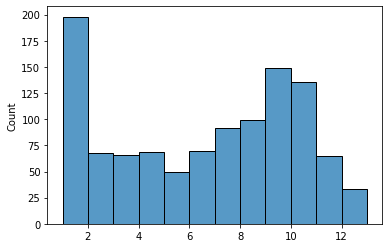

In [48]:
sns.histplot(label_counts.cpu())

In [87]:
graph.pid[relabelled == 79506]

tensor([61140000150, 61140000150], device='cuda:0')

In [88]:
relabelled[graph.pid == 61140000150]

tensor([ 5558,  5558,  5558,  5558,  5558,  5558,  5558, 79506, 79506],
       device='cuda:0')

In [93]:
relabelled[graph.pid == 61140000150] = 5558

In [94]:
sparse_score_segments(relabelled, graph.pid, graph.signal_true_edges)

(tensor(0.9684, device='cuda:0'),
 tensor(0.9585, device='cuda:0'),
 tensor(0.9634, device='cuda:0'))

## Scan over events

In [147]:
model = model.to(device)

In [148]:
true_positive, true, positive = 0, 0, 0
unstitched_scores = []
stitched_scores = []

with torch.no_grad():
    for graph in model.valset:
        input_data = model.get_input_data(graph).to(device)
        input_graph = torch.cat(
            [graph.edge_index, graph.edge_index.flip(0)], dim=-1
        ).to(device)
        output = torch.sigmoid(
            model(
                input_data,
                input_graph,
                graph.labels.to(device),
                graph.label_pairs.to(device),
            )
        )

        preds = output.squeeze() > 0.98
        truth = graph.pid_pairs[0] == graph.pid_pairs[1]

        true += truth.sum().float().cpu()
        positive += preds.sum().float().cpu()
        true_positive += (truth.bool().cpu() & preds.cpu()).sum().float()

        # Eff, pur, auc
        eff = true_positive / true
        pur = true_positive / positive

        print(eff, pur)

        labels = labelSegments(graph.edge_index[:, graph.y.bool()], len(graph.x))
        unstitched_scores.append(
            sparse_score_segments(labels, graph.pid, graph.signal_true_edges)[2].cpu()
        )

        connected_segments = labelSegments(graph.label_pairs[:, preds], len(labels))
        relabelled = connected_segments[labels]
        stitched_scores.append(
            sparse_score_segments(relabelled, graph.pid, graph.signal_true_edges)[
                2
            ].cpu()
        )

tensor(0.7963) tensor(0.8776)
tensor(0.8558) tensor(0.9271)
tensor(0.8693) tensor(0.9110)
tensor(0.8488) tensor(0.8969)
tensor(0.8250) tensor(0.9041)
tensor(0.8222) tensor(0.9024)
tensor(0.8275) tensor(0.8900)
tensor(0.8159) tensor(0.8972)
tensor(0.8138) tensor(0.8986)
tensor(0.8143) tensor(0.8835)
tensor(0.8129) tensor(0.8767)
tensor(0.8154) tensor(0.8797)
tensor(0.8148) tensor(0.8767)
tensor(0.8174) tensor(0.8664)
tensor(0.8207) tensor(0.8640)
tensor(0.8127) tensor(0.8625)
tensor(0.8169) tensor(0.8652)
tensor(0.8103) tensor(0.8654)
tensor(0.8046) tensor(0.8646)
tensor(0.8080) tensor(0.8663)
tensor(0.8056) tensor(0.8642)
tensor(0.8058) tensor(0.8673)
tensor(0.8118) tensor(0.8644)
tensor(0.8088) tensor(0.8672)
tensor(0.8067) tensor(0.8664)
tensor(0.8056) tensor(0.8686)
tensor(0.8030) tensor(0.8655)
tensor(0.8003) tensor(0.8698)
tensor(0.8004) tensor(0.8662)
tensor(0.7994) tensor(0.8636)
tensor(0.7989) tensor(0.8638)
tensor(0.7992) tensor(0.8651)
tensor(0.7972) tensor(0.8653)
tensor(0.7

In [149]:
torch.mean(torch.stack(unstitched_scores)), torch.std(torch.stack(unstitched_scores))

(tensor(0.9230), tensor(0.0083))

In [150]:
torch.mean(torch.stack(stitched_scores)), torch.std(torch.stack(stitched_scores))

(tensor(0.9504), tensor(0.0078))

### Test impurities

First, check I can recover 100% performance somehow...

In [156]:
labels = labelSegments(graph.signal_true_edges, len(graph.x))

In [157]:
sparse_score_segments(labels, graph.pid, graph.signal_true_edges)

(tensor(0.9993, device='cuda:0'),
 tensor(0.9987, device='cuda:0'),
 tensor(0.9990, device='cuda:0'))

In [136]:
sparse_score_segments(graph.pid, graph.pid, graph.signal_true_edges)

(tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'))

Consider losing 1% purity of these edges (i.e. consider merging long tracks...)

In [158]:
unique_labels, label_counts = labels.unique(return_counts=True)

In [159]:
long_tracks = unique_labels[label_counts > 6]

In [160]:
impurity = 0.01
tracks_to_merge = long_tracks[torch.randperm(len(long_tracks))][
    : int(2 * impurity * len(long_tracks))
]
tracks_to_merge_to = tracks_to_merge[: int(impurity * len(long_tracks))]
tracks_to_merge_from = tracks_to_merge[int(impurity * len(long_tracks)) :]

In [161]:
for track_to, track_from in zip(tracks_to_merge_to, tracks_to_merge_from):
    print(track_to, track_from)
    labels[labels == track_from] = track_to

tensor(5492, device='cuda:0') tensor(5007, device='cuda:0')
tensor(2525, device='cuda:0') tensor(345, device='cuda:0')
tensor(6209, device='cuda:0') tensor(8106, device='cuda:0')
tensor(1019, device='cuda:0') tensor(7565, device='cuda:0')
tensor(587, device='cuda:0') tensor(302, device='cuda:0')
tensor(6874, device='cuda:0') tensor(8715, device='cuda:0')


In [162]:
sparse_score_segments(labels, graph.pid, graph.signal_true_edges)

(tensor(0.9831, device='cuda:0'),
 tensor(0.9905, device='cuda:0'),
 tensor(0.9868, device='cuda:0'))

In [163]:
labels = labelSegments(graph.edge_index[:, graph.y.bool()], len(graph.x))

In [164]:
sparse_score_segments(labels, graph.pid, graph.signal_true_edges)

(tensor(0.9663, device='cuda:0'),
 tensor(0.9330, device='cuda:0'),
 tensor(0.9493, device='cuda:0'))

In [165]:
labels

tensor([    0,     1,     2,  ..., 98775, 98776, 98777], device='cuda:0')

### Debug scoring function

In [133]:
def sparse_score_segments(labels, pids, signal_pids):

    unique_pids, new_pids = pids.unique(return_inverse=True)
    _, new_labels = labels.unique(return_inverse=True)
    (
        signal_segments_pids,
        unique_signal_segments_pids,
        pid_count,
    ) = get_unique_signal_segments(new_labels, new_pids, signal_pids)

    iou, segment_count = get_jaccard_matrix(
        new_labels,
        new_pids,
        pid_count,
        signal_segments_pids,
        unique_signal_segments_pids,
    )

    sparse_segment_count = sp.coo_matrix(
        (
            segment_count[unique_signal_segments_pids[0]].cpu(),
            unique_signal_segments_pids.cpu().numpy(),
        )
    ).tocsr()
    sparse_pid_count = sp.coo_matrix(
        (
            pid_count[unique_signal_segments_pids[1]].cpu(),
            unique_signal_segments_pids.cpu().numpy(),
        )
    ).tocsr()

    segment_pur = (
        iou.multiply(sparse_segment_count).sum()
        / segment_count[unique_signal_segments_pids[0]].sum()
    )
    segment_eff = (
        iou.multiply(sparse_pid_count).sum()
        / pid_count[unique_signal_segments_pids[1]].sum()
    )

    segment_f1 = 2 * segment_pur * segment_eff / (segment_pur + segment_eff)

    return segment_pur, segment_eff, segment_f1


def get_jaccard_matrix(
    labels, pids, pid_count, signal_segments_pids, unique_signal_segments_pids
):

    sparse_intersection = sp.coo_matrix(
        (np.ones(signal_segments_pids.shape[1]), signal_segments_pids.cpu().numpy())
    ).tocsr()

    segment_count = labels.unique(return_counts=True)[1]

    union_counts = (
        segment_count[unique_signal_segments_pids[0]]
        + pid_count[unique_signal_segments_pids[1]]
    )
    sparse_sum = sp.coo_matrix(
        (union_counts.cpu(), unique_signal_segments_pids.cpu().numpy())
    ).tocsr()
    sparse_union = sparse_sum - sparse_intersection
    sparse_union.data = 1 / sparse_union.data
    iou = sparse_intersection.multiply(sparse_union)

    return iou, segment_count


def get_unique_signal_segments(labels, pids, signal_pids):

    labels_unique, labels_inverse, labels_counts = labels.unique(
        return_counts=True, return_inverse=True
    )

    segments_pids = torch.stack([labels, pids])
    is_signal = torch.isin(pids, pids[signal_pids]) & (
        labels_counts[labels_inverse] >= 3
    )

    signal_unique, signal_count = pids[is_signal].unique(return_counts=True)  #
    new_counts = torch.zeros(len(pids)).long().cuda()  #
    new_counts[
        signal_unique
    ] = signal_count  # These three lines define whether to sum the FULL size of a track, or just those hits in signal segments

    signal_segments_pids = segments_pids[:, is_signal]
    unique_signal_segments_pids = signal_segments_pids.unique(dim=1)

    return signal_segments_pids, unique_signal_segments_pids, new_counts

In [106]:
labels, pids, signal_pids = labels, graph.pid, graph.signal_true_edges

In [107]:
unique_pids, new_pids = pids.unique(return_inverse=True)
_, new_labels = labels.unique(return_inverse=True)

In [108]:
labels_unique, labels_inverse, labels_counts = new_labels.unique(
    return_counts=True, return_inverse=True
)

segments_pids = torch.stack([new_labels, new_pids])
is_signal = torch.isin(new_pids, new_pids[signal_pids]) & (
    labels_counts[labels_inverse] >= 3
)

In [117]:
signal_unique, signal_count = new_pids[is_signal].unique(return_counts=True)

In [118]:
new_pids

tensor([ 100, 6973, 1807,  ..., 2459,    0, 1155], device='cuda:0')

In [119]:
signal_unique

tensor([   1,    4,    7,   12,   16,   18,   19,   20,   22,   24,   26,   27,
          29,   32,   33,   36,   41,   45,   53,   54,   55,   58,   68,   75,
          81,   82,   84,   86,   87,   89,   92,   96,  103,  107,  109,  112,
         123,  128,  132,  141,  143,  156,  157,  159,  167,  171,  173,  183,
         191,  192,  194,  200,  203,  206,  207,  208,  209,  345,  347,  354,
         355,  357,  358,  365,  371,  375,  384,  398,  465,  477,  507,  510,
         532,  536,  539,  545,  548,  551,  558,  566,  569,  571,  579,  580,
         583,  643,  662,  667,  674,  679,  704,  705,  706,  708,  709,  711,
         712,  726,  736,  737,  811,  812,  818,  821,  829,  832,  834,  838,
         842,  849,  853,  854,  857,  858,  867,  874,  876,  887,  888,  897,
         898,  906,  954,  958,  966,  973,  976,  978, 1006, 1008, 1056, 1083,
        1105, 1106, 1107, 1110, 1129, 1169, 1181, 1206, 1207, 1208, 1212, 1214,
        1225, 1243, 1244, 1249, 1250, 12

In [124]:
new_counts = torch.zeros(len(new_pids)).long().cuda()

In [125]:
new_counts[signal_unique] = signal_count

In [126]:
new_counts

tensor([0, 7, 0,  ..., 0, 0, 0], device='cuda:0')